iter:50 training loss: 0.01597757264971733, val loss: 0.015837477520108223
iter:100 training loss: 0.006220136769115925, val loss: 0.006315017584711313
iter:150 training loss: 0.004643373657017946, val loss: 0.004652052652090788
iter:200 training loss: 0.003386578056961298, val loss: 0.0033981637097895145
iter:250 training loss: 0.002738011535257101, val loss: 0.002800839487463236
iter:300 training loss: 0.002503329422324896, val loss: 0.002580619417130947
iter:350 training loss: 0.0024153878912329674, val loss: 0.0024969277437776327
iter:400 training loss: 0.0023714059498161077, val loss: 0.0024533909745514393
iter:450 training loss: 0.0023456700146198273, val loss: 0.0024267551489174366
iter:500 training loss: 0.002329688984900713, val loss: 0.0024097044952213764
iter:550 training loss: 0.002319545717909932, val loss: 0.0023987130261957645
iter:600 training loss: 0.002312977332621813, val loss: 0.0023915108758956194
iter:650 training loss: 0.00230866065248847, val loss: 0.00238673621

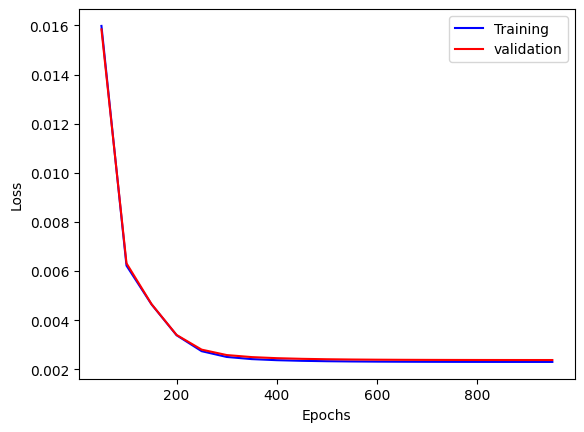

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px


def visualise_tensor(data):
    data = data.detach().numpy()

    ## Create colormap (red to blue)
    colormap = 'RdBu_r'
    # Plot the matrix
    fig = px.imshow(data, color_continuous_scale=colormap, zmin=-1, zmax=1)
    fig.show()
    fig.data = ()

input_size = 20
hidden_layer_size= 5
output_size = input_size
learning_rate = 0.01
max_iters = 1000
dataset_size = 1024
sparsity = 1.0 # appears only one in 100 times
batch_size = 32

decay_factor = 0.95
iters = []
loss_value = []
val_loss_value = []

imp_vector =torch.tensor([0.7**i for i in range(input_size)])


def get_l1_penalty():
    l1_penalty = 0
    for param in model.parameters():
        if param.requires_grad:
            l1_penalty += torch.norm(param, p=1)
    return l1_penalty

def sample_data():
    # TODO Implement mini batch
    a,b = training_dataset.shape
    sparsity_mat = torch.bernoulli(torch.full((a,b), sparsity))
    X = training_dataset*sparsity_mat
    return X, X

def sample_validation_data():
    a,b = validation_dataset.shape
    sparsity_mat = torch.bernoulli(torch.full((a,b), sparsity))
    X = validation_dataset*sparsity_mat
    return X, X


def get_loss(target, output):
    loss = (imp_vector*((target-output)**2)).mean()
    return loss


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_layer_size, bias= False)
        self.layer2 = nn.Linear(hidden_layer_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, input, targets = None):
         # Input is (B,I)
        logits = self.layer1(input) # (B, dim)
        
        logits = self.layer2(logits)

        # layer_1_weight = self.layer1.weight.data # (dim, I)
        # logits = logits @ layer_1_weight # (B, dim) * (dim, I) -> (B,I)
        # logits += self.layer2.bias

        logits = self.relu(logits)
        if targets is None:
            return logits
        else:
            loss = get_loss(targets, logits)
            return logits, loss

training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model()

LOAD_MODEL = False
PATH = "models/basic_linear_0.99.bin"
if LOAD_MODEL:
    model = Model()
    model.load_state_dict(torch.load(PATH))
    model.eval()
else:
    optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
    start_time = time.time()
    step_value = max_iters/20
    for i in range(1, max_iters):
        X, Y = sample_data()
        logits, loss = model(X, Y)
    
        if i%step_value ==0 :
            model.eval()
            with torch.no_grad():
                X_V,Y_V = sample_validation_data()
                _, val_loss = model(X_V, Y_V)
                iters.append(i)
                loss_value.append(loss.item())
                val_loss_value.append(val_loss.item())
                print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
            model.train()

        optimizer.zero_grad(set_to_none=True)
        #loss+= get_l1_penalty()
        loss.backward()
        optimizer.step()


    end_time = time.time()
    print(f"Took {end_time-start_time}s for {max_iters} epochs")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(iters,loss_value, color='blue', label="Training")
    plt.plot(iters, val_loss_value, "red", label = "validation")
    plt.legend()
    plt.show()




In [48]:


w1 = model.layer1.weight
w2 = model.layer2.weight
b1 = model.layer1.bias

b2 = model.layer2.bias
visualise_tensor(torch.transpose(w1,0,1)@w1)
# visualise_tensor(w2@w1)
visualise_tensor(b2.data.reshape(-1,1))

In [49]:
# Norm of embedding
norm = [0 for i in range(input_size)]
for i in range(input_size):
    idx = torch.zeros(input_size)
    idx[i] = 1
    idx = w1@idx
    norm[i] = idx.norm()
norm = torch.tensor(norm)
visualise_tensor(norm.reshape(-1,1))


# Interference
dot = [0 for i in range(input_size)]
for i in range(input_size):
    s = 0
    embed_a = w1[:,i]
    for j in range(input_size):
        if i==j:
            continue
        embed_b = w1[:,j]
        s+= (torch.dot(embed_a,embed_b))**2
    
    dot[i] = s

dot = torch.tensor(dot)
print(dot)
visualise_tensor(dot.reshape(-1,1))


tensor([3.4873e-02, 8.9666e-04, 2.4861e-02, 3.8390e-02, 7.5446e-02, 6.1855e-02,
        1.7218e-04, 2.5653e-04, 3.6364e-05, 5.9639e-05, 3.6480e-05, 1.1863e-04,
        1.6132e-05, 6.6761e-05, 1.4904e-05, 2.3233e-05, 1.4600e-05, 1.7627e-05,
        2.1267e-05, 6.6085e-06])


In [62]:
PATH = "../models/basic_relu_0.03.bin"
torch.save(model.state_dict(), PATH)
